In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from time import gmtime, strftime
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.stats import zscore
from sklearn.model_selection import ShuffleSplit,cross_val_score,train_test_split
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor


In [9]:
my_path = str(os.getcwd())
X_train = np.load(my_path+'/.data/X_train_surge_new.npz')
Y_train = pd.read_csv(my_path+'/.data/Y_train_surge.csv')
X_test = np.load(my_path+'/.data/X_test_surge_new.npz')
print(X_train.files)
print(Y_train.columns)
print(Y_train)
Y_train = np.array(Y_train)
print(Y_train)

['id_sequence', 't_slp', 'slp', 't_surge1_input', 'surge1_input', 't_surge2_input', 'surge2_input', 't_surge1_output', 't_surge2_output']
Index(['id_sequence', 'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3',
       'surge1_t4', 'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8',
       'surge1_t9', 'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3',
       'surge2_t4', 'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8',
       'surge2_t9'],
      dtype='object')
      id_sequence  surge1_t0  surge1_t1  surge1_t2  surge1_t3  surge1_t4  \
0               1   0.586936   1.069580   0.767928  -0.100162   0.070775   
1               2   0.767928  -0.100162   0.070775  -0.244285  -0.354891   
2               3   0.070775  -0.244285  -0.354891  -0.928031  -0.773853   
3               4  -0.354891  -0.928031  -0.773853  -0.375001  -0.361594   
4               5  -0.773853  -0.375001  -0.361594  -0.210768   0.288635   
...           ...        ...        ...        ...        ...        ... 

In [3]:
def split_on_index(X,Y,train_index,test_index):
    #un peu lent mais ça va (à cause de la copie de slp)
    
    #X
    files = X.files
    X_train = {}
    X_test = {}
    for f in files:
        #print(f)
        X_train[f] = X[f][train_index]
        X_test[f] = X[f][test_index]
    
    #Y doit être déjà un array
    #columns = Y.columns
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    """for f in columns:
        #print(f)
        Y_train[f] = Y[f][train_index]
        Y_test[f] = Y[f][test_index]"""
    
    return X_train,Y_train,X_test,Y_test

def prepare_slp(slp):
    #slp = X_train['slp']
    
    n = len(slp)
    #print(n)
    #prepare slp:
    slpflat = []
    #slp = slp - np.mean(slp)
    for i in range(n):
        slpflat.append(slp[i].flatten())

    slpflat = np.array(slpflat)
    #normalize
    #slpflat = zscore(slpflat)
    #print(slpflat.shape)

    return slpflat

def metric_one_surge(y_true,y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    score = (weights*(y_true-y_pred)**2).mean()
    return score

In [4]:
#prepare slp, flatten it once
slp = X_train["slp"]
slp_flat = prepare_slp(slp)

In [33]:
nbs = 10

ss = ShuffleSplit(n_splits=nbs,test_size=0.1)

size_N = 25
start_N = 15
step_N = 1

size_nb = 10
start_nb = 10
step_nb = 2

N_max = start_N+size_N*step_N

#just to give to shuffle split
X_ind = np.zeros(5599)

error = np.zeros((nbs,size_N,size_nb))

for s, (train_index, test_index) in enumerate(ss.split(X_ind)):
    print(s)
    #x_train,y_train,x_test,y_test = split_on_index(X_train,Y_train,train_index,test_index)
    #print(y_train)
    
    
    #PCA, (normalisation), KNN
    slp_train_flat = slp_flat[train_index]
    surge1_input_train = X_train['surge1_input'][train_index]
    surge_train = Y_train[:,1:][train_index]
    surge_train1 = surge_train[:,:10]
    
    print("normalize train")
    m = np.mean(slp_train_flat)
    std = np.std(slp_train_flat)
    slp_train_flat = (slp_train_flat-m)/std
    
    print("PCA")
    pca = PCA(n_components=N_max)
    slp_tr_LD = pca.fit_transform(slp_train_flat)
    
    mp = np.mean(slp_tr_LD)
    stdp = np.std(slp_tr_LD)
    slp_tr_LD = (slp_tr_LD-mp)/stdp
    print(slp_tr_LD.shape)

    xtr = []
    for i in range(len(slp_tr_LD)):
        xtr.append(np.concatenate((surge1_input_train[i],slp_tr_LD[i])))
    xtr = np.array(xtr)
    print(xtr.shape)
    
    print("prepare data test")
    slp_test_flat = slp_flat[test_index]
    surge1_input_test = X_train['surge1_input'][test_index]
    surge_test = Y_train[:,1:][test_index]
    surge_test1 = surge_test[:,:10]
    
    print("PCA test")
    slp_test_flat = (slp_test_flat-m)/std
    slp_te_LD = pca.transform(slp_test_flat)
    slp_te_LD = (slp_te_LD-mp)/stdp
    
    xte = []
    for i in range(len(slp_te_LD)):
        xte.append(np.concatenate((surge1_input_test[i],slp_te_LD[i])))
    xte = np.array(xte)
    print(xte.shape)
    
    
    for iN in range(0,size_N):
        
        N = iN*step_N+start_N
        print("PCA :", N)
        
        for inb in range(0,size_nb):
            nb = inb*step_nb+start_nb
            
            x = xtr[:,:(10+N)]
            
            clf = KNeighborsRegressor(n_neighbors=nb,weights='distance')

            clf.fit(x,surge_train1)

            #print("end train")

            #print("start test")

            x = xte[:,:(10+N)]

            ypred = clf.predict(x)
            
            error[s,iN,inb]=metric_one_surge(ypred,surge_test1)
            #print(metric_one_surge(ypred,surge_test1))
        
        
        
        
    
    
    
    

0
normalize train
PCA
(5039, 40)
(5039, 50)
prepare data test
PCA test
(560, 50)
PCA : 15
PCA : 16
PCA : 17
PCA : 18
PCA : 19
PCA : 20
PCA : 21
PCA : 22
PCA : 23
PCA : 24
PCA : 25
PCA : 26
PCA : 27
PCA : 28
PCA : 29
PCA : 30
PCA : 31
PCA : 32
PCA : 33
PCA : 34
PCA : 35
PCA : 36
PCA : 37
PCA : 38
PCA : 39
1
normalize train
PCA
(5039, 40)
(5039, 50)
prepare data test
PCA test
(560, 50)
PCA : 15
PCA : 16
PCA : 17
PCA : 18
PCA : 19
PCA : 20
PCA : 21
PCA : 22
PCA : 23
PCA : 24
PCA : 25
PCA : 26
PCA : 27
PCA : 28
PCA : 29
PCA : 30
PCA : 31
PCA : 32
PCA : 33
PCA : 34
PCA : 35
PCA : 36
PCA : 37
PCA : 38
PCA : 39
2
normalize train
PCA
(5039, 40)
(5039, 50)
prepare data test
PCA test
(560, 50)
PCA : 15
PCA : 16
PCA : 17
PCA : 18
PCA : 19
PCA : 20
PCA : 21
PCA : 22
PCA : 23
PCA : 24
PCA : 25
PCA : 26
PCA : 27
PCA : 28
PCA : 29
PCA : 30
PCA : 31
PCA : 32
PCA : 33
PCA : 34
PCA : 35
PCA : 36
PCA : 37
PCA : 38
PCA : 39
3
normalize train
PCA
(5039, 40)
(5039, 50)
prepare data test
PCA test
(560, 50)
P

KeyboardInterrupt: 

[[0.36212441 0.36182929 0.36093087 0.36045091 0.36059228 0.36163339
  0.36254374 0.36287861 0.36310605 0.36386291]
 [0.36069352 0.36130835 0.36028008 0.35974176 0.36017662 0.36101754
  0.36130054 0.36152467 0.3621269  0.36258655]
 [0.36119254 0.36152403 0.36032453 0.3597881  0.36032958 0.36034948
  0.3616887  0.36228061 0.36279999 0.36346489]
 [0.36067482 0.36020287 0.35897471 0.35868946 0.35912758 0.35991749
  0.3607317  0.3613936  0.36196625 0.36248746]
 [0.3597097  0.35915068 0.35875247 0.35823965 0.35872016 0.35949653
  0.36047915 0.36088385 0.36166782 0.36228284]
 [0.36014021 0.35906765 0.35779316 0.35798964 0.35863084 0.35921397
  0.35999883 0.36065664 0.36156369 0.36192811]
 [0.35998363 0.3589459  0.35814933 0.35791292 0.35864946 0.35908649
  0.36011112 0.36055609 0.36115924 0.36177992]
 [0.35997904 0.35831307 0.35762777 0.35767666 0.35832477 0.35941999
  0.36030395 0.36035002 0.36095041 0.36134667]
 [0.3596163  0.35909215 0.35768847 0.35815602 0.35873335 0.35913812
  0.35919878

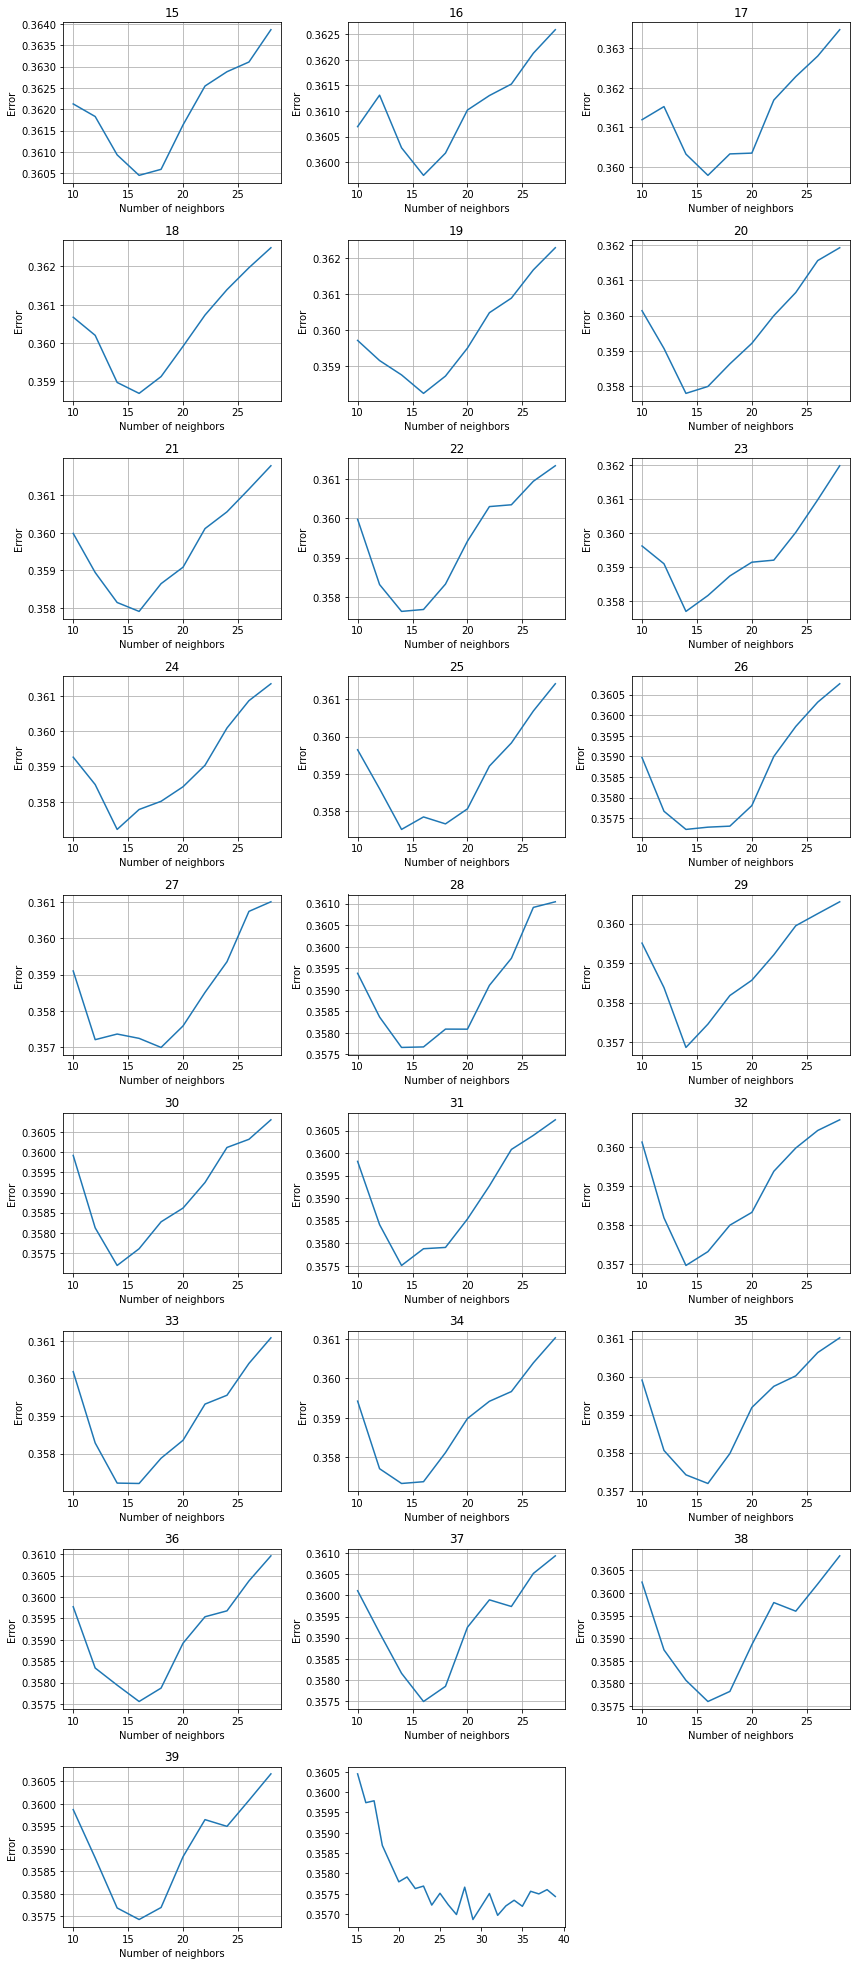

In [25]:
#print(error)
#print(error[0])
error_avg = np.mean(error,axis=0)
print(error_avg)
XN = np.array(range(0,size_N))*step_N+start_N
Xnb = np.array(range(0,size_nb))*step_nb+start_nb

plt.figure(figsize=(12, 30))
for i in range(0,size_N):
    plt.subplot(10,3, i+1)
    plt.plot(Xnb,error_avg[i])
    plt.title(i*step_N+start_N)
    plt.xlabel("Number of neighbors")
    plt.ylabel("Error")
    plt.grid()
plt.tight_layout()

plt.subplot(10,3,size_N+1)
min_error = np.min(error_avg,axis=1)

plt.plot(XN,min_error)
print(np.argmin(min_error)*step_N+start_N)
plt.tight_layout()

print(XN)

# 15 neighbors PCA 28

In [28]:
nbs = 10

ss = ShuffleSplit(n_splits=nbs,test_size=0.1)

size_N = 10
start_N = 15
step_N = 2

size_nb = 10
start_nb = 1
step_nb = 1

N_max = start_N+size_N*step_N

#just to give to shuffle split
X_ind = np.zeros(5599)

error = np.zeros((nbs,size_N,size_nb))

for s, (train_index, test_index) in enumerate(ss.split(X_ind)):
    print(s)
    #x_train,y_train,x_test,y_test = split_on_index(X_train,Y_train,train_index,test_index)
    #print(y_train)
    
    
    #PCA, (normalisation), KNN
    slp_train_flat = slp_flat[train_index]
    surge1_input_train = X_train['surge2_input'][train_index]
    surge_train = Y_train[:,1:][train_index]
    surge_train1 = surge_train[:,10:]
    
    print("normalize train")
    m = np.mean(slp_train_flat)
    std = np.std(slp_train_flat)
    slp_train_flat = (slp_train_flat-m)/std
    
    print("PCA")
    pca = PCA(n_components=N_max)
    slp_tr_LD = pca.fit_transform(slp_train_flat)
    
    mp = np.mean(slp_tr_LD)
    stdp = np.std(slp_tr_LD)
    slp_tr_LD = (slp_tr_LD-mp)/stdp
    print(slp_tr_LD.shape)

    xtr = []
    for i in range(len(slp_tr_LD)):
        xtr.append(np.concatenate((surge1_input_train[i],slp_tr_LD[i])))
    xtr = np.array(xtr)
    print(xtr.shape)
    
    print("prepare data test")
    slp_test_flat = slp_flat[test_index]
    surge1_input_test = X_train['surge2_input'][test_index]
    surge_test = Y_train[:,1:][test_index]
    surge_test1 = surge_test[:,10:]
    
    print("PCA test")
    slp_test_flat = (slp_test_flat-m)/std
    slp_te_LD = pca.transform(slp_test_flat)
    slp_te_LD = (slp_te_LD-mp)/stdp
    
    xte = []
    for i in range(len(slp_te_LD)):
        xte.append(np.concatenate((surge1_input_test[i],slp_te_LD[i])))
    xte = np.array(xte)
    print(xte.shape)
    
    
    for iN in range(0,size_N):
        
        N = iN*step_N+start_N
        print("PCA :", N)
        
        for inb in range(0,size_nb):
            nb = inb*step_nb+start_nb
            
            x = xtr[:,:(10+N)]
            
            clf = KNeighborsRegressor(n_neighbors=nb,weights='distance')

            clf.fit(x,surge_train1)

            #print("end train")

            #print("start test")

            x = xte[:,:(10+N)]

            ypred = clf.predict(x)
            
            error[s,iN,inb]=metric_one_surge(ypred,surge_test1)
            #print(metric_one_surge(ypred,surge_test1))
        
        
        
        
    

0
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
PCA : 29
PCA : 31
PCA : 33
1
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
PCA : 29
PCA : 31
PCA : 33
2
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
PCA : 29
PCA : 31
PCA : 33
3
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
PCA : 29
PCA : 31
PCA : 33
4
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
PCA : 29
PCA : 31
PCA : 33
5
normalize train
PCA
(5039, 35)
(5039, 45)
prepare data test
PCA test
(560, 45)
PCA : 15
PCA : 17
PCA : 19
PCA : 21
PCA : 23
PCA : 25
PCA : 27
P

[[[0.26060348 0.19888336 0.19455564 0.19866423 0.20283305 0.208256
   0.21377699 0.22058872 0.22180419 0.22765053]
  [0.26554959 0.19738754 0.19546672 0.20524332 0.20614381 0.21425365
   0.21589953 0.22008223 0.22307771 0.22722176]
  [0.25208839 0.1914378  0.18997211 0.19939858 0.2028656  0.21164059
   0.21483479 0.21811833 0.22207784 0.22626704]
  [0.25247947 0.19630548 0.18929294 0.19347408 0.20080629 0.20906989
   0.21425709 0.2180737  0.22335438 0.22836596]
  [0.25904159 0.19682925 0.18885931 0.18988206 0.19833077 0.20684614
   0.21145146 0.2165777  0.22210161 0.22657596]
  [0.2604387  0.19104232 0.18853278 0.19032998 0.19943966 0.20500571
   0.21223733 0.21635655 0.22156007 0.22610209]
  [0.26409563 0.19258185 0.18741914 0.19424948 0.19978519 0.20590533
   0.21105638 0.21790416 0.22136764 0.22542651]
  [0.26825388 0.19176816 0.18714916 0.19368208 0.20218902 0.20526493
   0.21167262 0.21654652 0.2194159  0.2251082 ]
  [0.27115882 0.19665044 0.1905408  0.19251666 0.20077911 0.206570

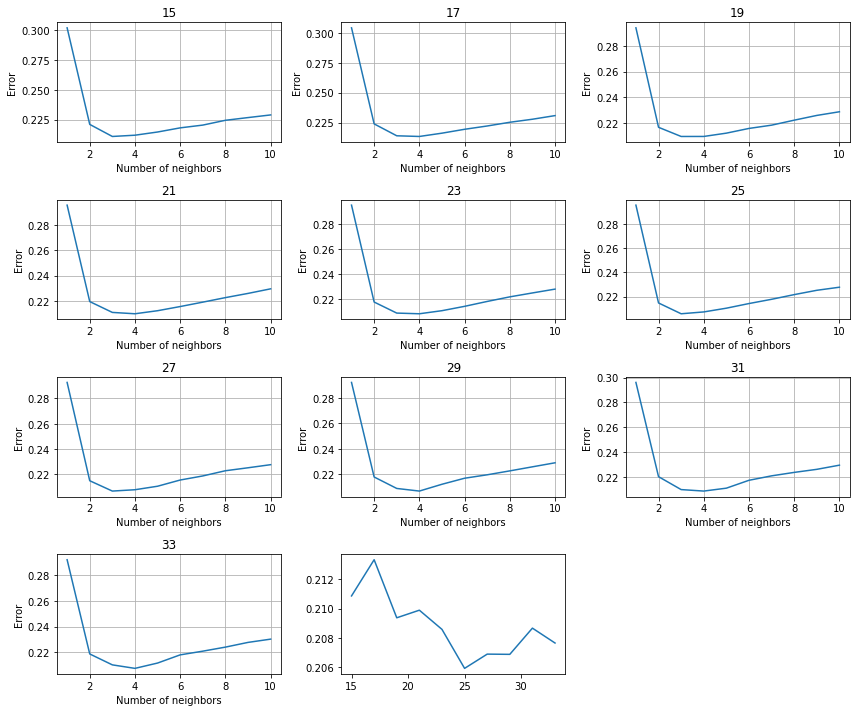

In [30]:
print(error)
#print(error[0])
error_avg = np.mean(error,axis=0)
print(error_avg)
XN = np.array(range(0,size_N))*step_N+start_N
Xnb = np.array(range(0,size_nb))*step_nb+start_nb

plt.figure(figsize=(12, 10))
for i in range(0,size_N):
    plt.subplot(4,3, i+1)
    plt.plot(Xnb,error_avg[i])
    plt.title(i*step_N+start_N)
    plt.xlabel("Number of neighbors")
    plt.ylabel("Error")
    plt.grid()

plt.subplot(4,3,size_N+1)
min_error = np.min(error_avg,axis=1)

plt.plot(XN,min_error)
print(np.argmin(min_error)*step_N+start_N)
plt.tight_layout()

# 3 neighbors and PCA 25



In [5]:
# 15 neighbors PCA 28
# 3 neighbors and PCA 25

N1 = 28
N2 = 25
nb1 = 15
nb2 = 3

nbs = 10

ss = ShuffleSplit(n_splits=nbs,test_size=0.1)

error1 = np.zeros(nbs)
error2 = np.zeros(nbs)
#just to give to shuffle split
X_ind = np.zeros(5599)

for s, (train_index, test_index) in enumerate(ss.split(X_ind)):
    print(s)
    #x_train,y_train,x_test,y_test = split_on_index(X_train,Y_train,train_index,test_index)
    #print(y_train)
    
    slp_train_flat = slp_flat[train_index]
    surge_train = Y_train[:,1:][train_index]
    slp_test_flat = slp_flat[test_index]
    surge_test = Y_train[:,1:][test_index]
    
    
    #print("normalize train")
    m = np.mean(slp_train_flat)
    std = np.std(slp_train_flat)
    slp_train_flat = (slp_train_flat-m)/std
    

    
    #CITY 1
    surge1_input_train = X_train['surge1_input'][train_index]
    surge_train1 = surge_train[:,:10]
    
    #PCA CITY 1
    pca1 = PCA(n_components=N1)
    slp_tr_LD1 = pca1.fit_transform(slp_train_flat)
    
    #NORMALIZE AFTER PCA1
    mp1 = np.mean(slp_tr_LD1)
    stdp1 = np.std(slp_tr_LD1)
    slp_tr_LD1 = (slp_tr_LD1-mp1)/stdp1

    xtr1 = []
    for i in range(len(slp_tr_LD1)):
        xtr1.append(np.concatenate((surge1_input_train[i],slp_tr_LD1[i])))
    xtr1 = np.array(xtr1)
    
    #TRAIN NB 1
    clf1 = KNeighborsRegressor(n_neighbors=nb1,weights='distance')

    clf1.fit(xtr1,surge_train1)
    
    #print("prepare data test")
    surge1_input_test = X_train['surge1_input'][test_index]
    surge_test1 = surge_test[:,:10]
    
    #print("PCA test")
    slp_test_flat = (slp_test_flat-m)/std
    slp_te_LD1 = pca1.transform(slp_test_flat)
    slp_te_LD1 = (slp_te_LD1-mp1)/stdp1
    
    xte1 = []
    for i in range(len(slp_te_LD1)):
        xte1.append(np.concatenate((surge1_input_test[i],slp_te_LD1[i])))
    xte1 = np.array(xte1)
    #print(xte1.shape)

    ypred1 = clf1.predict(xte1)

    error1[s] = metric_one_surge(ypred1,surge_test1)
    print("city 1",error1[s])
    
    
    #CITY2
    surge2_input_train = X_train['surge2_input'][train_index]
    surge_train2 = surge_train[:,10:]
    
    #PCA CITY 1
    pca2 = PCA(n_components=N2)
    slp_tr_LD2 = pca2.fit_transform(slp_train_flat)
    
    #NORMALIZE AFTER PCA1
    mp2 = np.mean(slp_tr_LD2)
    stdp2 = np.std(slp_tr_LD2)
    slp_tr_LD2 = (slp_tr_LD2-mp2)/stdp2

    xtr2 = []
    for i in range(len(slp_tr_LD2)):
        xtr2.append(np.concatenate((surge2_input_train[i],slp_tr_LD2[i])))
    xtr2 = np.array(xtr2)
    
    #TRAIN NB 1
    clf2 = KNeighborsRegressor(n_neighbors=nb2,weights='distance')

    clf2.fit(xtr2,surge_train2)
    
    #print("prepare data test")
    surge2_input_test = X_train['surge2_input'][test_index]
    surge_test2 = surge_test[:,10:]
    
    #print("PCA test")
    slp_te_LD2 = pca2.transform(slp_test_flat)
    slp_te_LD2 = (slp_te_LD2-mp2)/stdp2
    
    xte2 = []
    for i in range(len(slp_te_LD2)):
        xte2.append(np.concatenate((surge2_input_test[i],slp_te_LD2[i])))
    xte2 = np.array(xte2)
    #print(xte2.shape)

    ypred2 = clf2.predict(xte2)

    error2[s] = metric_one_surge(ypred2,surge_test2)
    print("city 2",error2[s])
    
    print(error1[s]+error2[s])


0
city 1 0.33575210437578845
city 2 0.22999171601871474
0.5657438203945032
1
city 1 0.36379351378811775
city 2 0.2249725522647291
0.5887660660528469
2
city 1 0.33418113760696216
city 2 0.17872608470909926
0.5129072223160615
3
city 1 0.3783658102539026
city 2 0.2000420751275476
0.5784078853814502
4
city 1 0.35234511521997836
city 2 0.21872365482267533
0.5710687700426537
5
city 1 0.3629105154869388
city 2 0.22062600456656745
0.5835365200535063
6
city 1 0.35648584199865413
city 2 0.1926835699857585
0.5491694119844126
7
city 1 0.3922260662684243
city 2 0.2314735871665353
0.6236996534349596
8
city 1 0.3745457543453152
city 2 0.20088138501716932
0.5754271393624845
9
city 1 0.3496557892858241
city 2 0.19990686260170776
0.5495626518875318


In [6]:
print(np.mean(error1+error2))

0.569828914091041


In [16]:
#prepare slp for train, flatten it once
slp_train = X_train["slp"]
print(slp_train.shape)
slp_train_flat = prepare_slp(slp_train)
print(slp_train_flat.shape)

slp_test = X_test["slp"]
slp_test_flat = prepare_slp(slp_test)

(5599, 40, 41, 41)
(5599, 67240)


In [18]:
N1 = 28
N2 = 25
nb1 = 15
nb2 = 3

surge_train = Y_train[:,1:]

#normalize train and test
m = np.mean(slp_train_flat)
std = np.std(slp_train_flat)
slp_train_flat = (slp_train_flat-m)/std
print(slp_train_flat.shape)
slp_test_flat = (slp_test_flat-m)/std


#CITY 1
surge1_input_train = X_train['surge1_input']
surge_train1 = surge_train[:,:10]

#PCA CITY 1
pca1 = PCA(n_components=N1)
slp_tr_LD1 = pca1.fit_transform(slp_train_flat)

#NORMALIZE AFTER PCA1
mp1 = np.mean(slp_tr_LD1)
stdp1 = np.std(slp_tr_LD1)
slp_tr_LD1 = (slp_tr_LD1-mp1)/stdp1
print(slp_tr_LD1.shape)

xtr1 = []
for i in range(len(slp_tr_LD1)):
    xtr1.append(np.concatenate((surge1_input_train[i],slp_tr_LD1[i])))
xtr1 = np.array(xtr1)

#TRAIN NB 1
clf1 = KNeighborsRegressor(n_neighbors=nb1,weights='distance')

print(xtr1.shape)
clf1.fit(xtr1,surge_train1)

#print("prepare data test")
surge1_input_test = X_test['surge1_input']

#print("PCA test")
slp_te_LD1 = pca1.transform(slp_test_flat)
slp_te_LD1 = (slp_te_LD1-mp1)/stdp1

xte1 = []
for i in range(len(slp_te_LD1)):
    xte1.append(np.concatenate((surge1_input_test[i],slp_te_LD1[i])))
xte1 = np.array(xte1)
#print(xte1.shape)

ypred1 = clf1.predict(xte1)

print(ypred1)


#CITY2
surge2_input_train = X_train['surge2_input']
surge_train2 = surge_train[:,10:]

#PCA CITY 1
pca2 = PCA(n_components=N2)
slp_tr_LD2 = pca2.fit_transform(slp_train_flat)

#NORMALIZE AFTER PCA1
mp2 = np.mean(slp_tr_LD2)
stdp2 = np.std(slp_tr_LD2)
slp_tr_LD2 = (slp_tr_LD2-mp2)/stdp2

xtr2 = []
for i in range(len(slp_tr_LD2)):
    xtr2.append(np.concatenate((surge2_input_train[i],slp_tr_LD2[i])))
xtr2 = np.array(xtr2)

#TRAIN NB 1
clf2 = KNeighborsRegressor(n_neighbors=nb2,weights='distance')

clf2.fit(xtr2,surge_train2)

#print("prepare data test")
surge2_input_test = X_test['surge2_input']

#print("PCA test")
slp_te_LD2 = pca2.transform(slp_test_flat)
slp_te_LD2 = (slp_te_LD2-mp2)/stdp2

xte2 = []
for i in range(len(slp_te_LD2)):
    xte2.append(np.concatenate((surge2_input_test[i],slp_te_LD2[i])))
xte2 = np.array(xte2)
#print(xte2.shape)

ypred2 = clf2.predict(xte2)

print(ypred2)

(5599, 67240)
(5599, 28)
(5599, 38)
[[-1.0600643  -0.90094986 -0.8077282  ... -0.47999328 -0.61990008
  -0.70667839]
 [ 0.67145757  0.76178817  0.37096641 ...  0.85569404  1.05007174
   0.76198915]
 [-0.33070225 -0.37888884 -0.45187658 ... -0.16488417 -0.08128497
  -0.05593942]
 ...
 [ 0.18450586  0.19906842  0.18302037 ...  0.35517281  0.23427535
   0.15851236]
 [ 0.35997727  0.3950795   0.62724623 ...  0.09410138  0.20988838
  -0.04149156]
 [ 0.66384217  0.6387066   0.67160531 ...  0.74960082  0.63715683
   0.38091028]]
[[ 0.05930108  0.00681564  0.22930155 ...  0.76937495  0.06322505
   1.12512495]
 [ 0.03854775  0.17273276  0.19995624 ...  0.23132429 -0.06367665
   0.18608599]
 [ 1.06513347  1.02274564  1.27004167 ... -0.16593124 -0.13866962
  -0.18369539]
 ...
 [ 0.85491855  0.72761083  0.79104436 ...  0.36854442  0.1488246
   0.03311064]
 [ 2.23475537  2.09885465  1.66593773 ...  1.88553494  2.0010462
   1.61449402]
 [ 0.62658578  0.65910194  0.92204133 ...  1.94781014  1.8422839

In [22]:
ypred = np.concatenate((ypred1,ypred2),axis=1)
print(ypred.shape)

(509, 20)


In [23]:
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
y_test = pd.DataFrame(data=ypred, columns=y_columns, index=X_test['id_sequence'])
y_test.to_csv('Y_test_PCANN.csv', index_label='id_sequence', sep=',')